For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week12-word-context-vectors

# Hist 3368 - Week 12: Word Context Vectors with Gensim

#### By Jo Guldi


#### Word Vectors vs. Word Embeddings 

Wordcount vectors are just what we’ve looked at: a simple count of words, with one integer per every word.  Wordcount embeddings are similar. But they typically add one more row of data or more per document.  That might mean that there’s a count of how many nouns, verbs, or adjectives there are per document. That might mean that there’s a count of bigrams, trigrams, fourgrams, or more – or multi-word phrases, plus or minus a word, called a “skipgram.”  These “hidden layers” in word embedding models mean an even richer model of which documents are like other documents. Because they factor in grammar and sentence structure as well as lexicon, they produce models that are very good at matching rhetorical style in text, and getting at the nuances of grammatical meaning. That is to say, they’re good at noticing when you mean “apple” the fruit (which you might eat or make into pie) or “apple” the computer (which you might turn on or off).  

Functionally, you use word embeddings just the way you use wordcount vectors. You can measure the distance between them, just like we did in our notebook this week.  You can subtract them, just as we did, to get a litmus test of what’s different between two periods of time, or which words are used to signify masculinity and femininity.  

*Previously, you've made word count vectors by brute force -- by 'grouping' your data by each word, then creating a word vector for each word, and using log likelihood to measure the most distinctive collocates of each word.

*This time, however, we'll use the GENSIM package of word embeddings to work on a larger-scale sample of debates. We'll use GENSIM's pre-built tools to do analysis comparative to what you did with cosine distance and vector subtraction:

     wv.vocab - which allows you to inspect the words in a vector 
     wv.most_similar() - which allows you to call up the words more likely to appear in the same context as a given keyword
     wv.similar_by_vector() -- which allows you to search for by vector. it thus allows you to find the words that commonly appear in the same context as a given keyword.  

#### Skill Building for Historical Analysis

By the end of this notebook, you'll know how to replicate most of the fancy work with vectors in the reading.  You'll be able to:
* use word context vectors to analyze the intellectual history of concept words like "freedom," "gay", or "woman," detecting how their context changed from moment to moment
* visualize changes to word concepts as a dendrogram
* use GENSIM's "most_similar()" to generate a list of the words most similar to any concept (for instance "freedom") at different moments over time
* visualize changes to the context of an individual word over time

### Load programs

In [78]:
import pandas as pd
import csv
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

Because Gensim likes data to be organized by sentence, let's create a function that breaks a string of text up into a list of strings, each of which is a sentence.

In [79]:
tokenizer = TreebankWordTokenizer()

def make_sentences(text):
    preprocessed_text = []
    for line in text:
        lower_case = line.lower()
        sentences = sent_tokenize(lower_case)
        tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
        preprocessed_text += tokenized_sentences
    return preprocessed_text

#### Load some Data

In [80]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [81]:
congress = pd.read_csv("congress1967-2010.csv")
all_data = congress[congress['year'] >= 1967]
all_data = congress[congress['year'] <= 1983]
#congress = pd.read_csv("eighties_data.csv")

In [82]:
all_data[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
0,0,0,Those who do not enjoy the privilege of the fl...,1967-01-10,The VICE PRESIDENT,16,1967,1,1967-01-01
1,1,1,Mr. President. on the basis of an agreement re...,1967-01-10,Mr. MANSFIELD,35,1967,1,1967-01-01
2,2,2,The Members of the Senate have heard the remar...,1967-01-10,The VICE PRESIDENT,40,1967,1,1967-01-01
3,3,3,The Chair lays before the Senate the following...,1967-01-10,The VICE PRESIDENT,151,1967,1,1967-01-01
4,4,4,Secretary of State.,1967-01-10,Mrs. AGNES BAGGETT,3,1967,1,1967-01-01


In [83]:
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year', 'speaker','Unnamed: 0', 'Unnamed: 0.1', 'word_count', 'month'], 1)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


*If you see a warning above, it isn't an error.*

In [84]:
all_data['index'] = np.arange(len(all_data)) # create an 'index' column

In [85]:
all_data.head()

,speech,month_year,5yrperiod,index
0,Those who do not enjoy the privilege of the fl...,1967-01-01,1965.0,0
1,Mr. President. on the basis of an agreement re...,1967-01-01,1965.0,1
2,The Members of the Senate have heard the remar...,1967-01-01,1965.0,2
3,The Chair lays before the Senate the following...,1967-01-01,1965.0,3
4,Secretary of State.,1967-01-01,1965.0,4


#### Downsample

In this exercise, the first pass, we're going to do some memory-intensive work on the computer by creating word context vectors 'by hand' -- i.e., using onyl SKLEARN's CountVectorizer() and .fit_transform + cosine distance and subtraction.  

Doing it this way is slower than loading some other packages that have been built specifically for working with large-scale wordcount vectors, where the code is packaged with high-dimensional math designed to make the comparisons run faster.

We're doing it this way, however, so that you can really see for yourself how a word vector is built and what's inside it at every moment.   

When we structure the data, build the vectors, subtract and measure the distance between vectors, we'll be able to inspect what's in the vector at every turn. You'd be able to do the math yourself if you looked more carefully.

Later in the notebook, we'll return to a 'word embedding' software package that uses high-dimensional math and hidden layers to make whip-fast vectors.

However, as we're doing old-fashioned vectors by hand, it'll go best if we "downsample" the data, taking a random sample of 5000 sentences spoken in Congress between 1985-2010.

Let's create some downsamples so we don't break the computer.

In [86]:
sample_l = all_data.sample(500000)
sample_m = sample_l.sample(50000)
sample = sample_m.sample(5000)

## Introducing Gensim, a Tool for Studying Word Embeddings

At this point in the code, we're shifting from word vectors made with SKLEARN to word "embeddings" made with the GENSIM package.

GENSIM uses higher-level math to condense the matrices, meaning that we'll be able to deal with more information than the downsized sample above. Word embeddings like GENSIM also typically have a "hidden layer" of modeling which includes information about word order and part-of-speech, designed to make the word vectors more accurate models of the way that words are used in sentences. 

In [87]:
import gensim 

Gensim wants to work with a dataset of texts where each row is a sentence, organized as a list of words.

#### Break the data into sentences

We'll need to break our dataframe of speeches into sentences.

NOTE: the lines below may take a while. Splitting sentences and words can be intensive on a dataset of this scale. If it's not working for you, try sample_m or sample where you see sample_l in the first line.

In [88]:
sentences_m = make_sentences(sample_m['speech']).copy() # <---- switch out sample_l to all_data, sample_s or sample_m here

In [89]:
sentences_m[:2]

[['without', 'objection', '.'], ['it', 'is', 'so', 'ordered', '.']]

We're now ready to model a larger set of data in Congress from 1985 to 2005 with the help of GENSIM.

### Setting up GENSIM

The first step is to "train" the GENSIM model with the function `gensim.models.Word2Vec()`. This function has a couple dozen parameters, some of which are more important than others.

Here are a few major ones. Only two are MANDATORY: these are marked with an asterisk:

1. `sentences*`: This is where you provide your data. It must be in a format of iterable of iterables.
2. `sg`: Your choice of training algorithm. There are two standard ways of training W2V vectors -- 'skipgram' and 'CBOW'. If you enter 1 here the skip-gram is applied; otherwise, the default is CBOW.
3. `size*`: This is the length of your resulting word vectors. If you have a large corpus (>few billion tokens) you can go up to 100-300 dimensions. Generally word vectors with more dimensions give better results.
4. `window`: This is the window of context words you are training on. In other words, how many words come before and after your given word. A good number is 4 here but this can vary depending on what you are interested in. For instance, if you are more interested in embeddings that embody semantic meaning, smaller window sizes work better. 
5. `alpha`: The learning rate of your model. If you are interested in machine learning experimentation with your vectors you may experiment with this parameter.
6. `seed` (int): This is the random seed for your random initialization. All deep learning models initialize the weights with random floats before training. This is a useful field if you want to replicate your experiments because giving this a seed will initialize 'randomly' deterministically.
7. `min_count`: This is the minimum frequency threshold. If a given word appears with lower frequency than provided it will be ignored. This is here because words with very low frequency are hard to train.
8. `iter`: This is the number of iterations(entire run) over the corpus, also known as epochs. Usually anything between 1-10 is ok. The trade offs are that if you have higher iterations, it will take longer to train and the model may overfit on your dataset. However, longer training will allow your vectors to perform better on tasks relevant to your dataset.

Most of these settings will not concern us. As you'll see below, we are only going to use four arguments.

In [90]:
congress_model = gensim.models.Word2Vec(
    sentences = sentences_m,
    min_count = 2, # remove words stated only once
    size = 100) # size of neuralnet layers; default is 100; higher for larger corpora

### Save the model

Let's also save our model in case we want to use it again in a later session.

In [91]:
congress_model.save('congress_model')
# hansard_model = gensim.models.Word2Vec.load('hansard_model') # to load a saved model

And you can load a model in the same way (remember this from our topic model)

In [92]:
congress_model = gensim.models.Word2Vec.load('congress_model') 

## What's in the model?

The method `wv.index2word` allows us to see the words in our model (but careful! congress_model.wv.vocab will print out every word in the corpus -- a very long list!)

In [93]:
congress_model.wv.index2word[:25]

['.',
 'the',
 'of',
 'to',
 'and',
 'in',
 'that',
 'a',
 'i',
 'is',
 'for',
 'this',
 'it',
 'be',
 'on',
 'we',
 'have',
 'not',
 'as',
 'from',
 'mr.',
 'by',
 'are',
 'will',
 'with']

The model itself is -- like the SKLEARN CountVectors model -- a matrix of vectors. Every row corresponds to the counts for one word. We can call the entire matrix or call up one row at a time.

In [94]:
congress_model.wv.vectors

array([[ 0.9497508 ,  0.5388141 , -0.99020994, ...,  0.6671687 ,
         0.6557476 , -0.99787366],
       [ 1.898388  ,  1.3836261 , -0.7037929 , ...,  0.22026233,
         1.1220571 , -1.2324567 ],
       [ 2.8528442 ,  0.46640474, -0.73352945, ..., -1.6343485 ,
         0.0521873 ,  0.17535599],
       ...,
       [-0.02920882,  0.0345541 , -0.01629957, ...,  0.03250856,
        -0.03081844, -0.04991218],
       [-0.02163864,  0.01278876, -0.06349212, ...,  0.0469236 ,
        -0.01660432,  0.00549504],
       [-0.01202568,  0.01915831, -0.01410175, ...,  0.05127973,
        -0.03262107,  0.00496207]], dtype=float32)

Here's the fourth row of the model, represented as a word and as a vector:

In [95]:
word = congress_model.wv.index2word[3]
word

'to'

In [96]:
congress_model.wv[word]

array([ 1.8547    ,  2.6101496 ,  1.4023896 , -0.40038246, -1.6957257 ,
       -1.6010624 , -1.4890159 , -0.56296825, -1.5947479 ,  0.05115319,
       -3.3448706 ,  0.7933605 ,  0.21241823, -1.5080615 , -0.14215976,
       -0.9702999 , -0.05880565,  0.6856464 ,  1.1883504 ,  2.3045168 ,
        1.097691  , -2.9052901 , -0.12523824, -0.7668554 ,  0.04258798,
       -0.0991515 , -1.983064  ,  0.49641177, -0.4767607 , -0.5308826 ,
       -0.03443328,  0.6535829 ,  1.4857819 ,  0.44182244, -3.0937066 ,
       -0.40200487, -0.3406603 ,  2.2243586 , -2.1556952 , -2.007565  ,
        0.1892345 , -0.17068812,  0.19394699,  0.7497749 ,  2.1654997 ,
        1.5865097 , -0.05160783, -0.05235121, -1.0311556 , -1.8316562 ,
        1.8760641 ,  3.5960283 , -2.362327  , -0.74376845, -2.3152058 ,
        1.6217569 ,  0.7249568 ,  1.2144265 , -2.5520818 , -0.03346527,
        1.8171828 ,  0.23804674,  1.0472482 , -0.01224112, -0.4481276 ,
        1.2732201 , -1.6273466 ,  2.3647141 ,  0.01966456, -1.89

In [97]:
congress_model.wv.vectors[3]

array([ 1.8547    ,  2.6101496 ,  1.4023896 , -0.40038246, -1.6957257 ,
       -1.6010624 , -1.4890159 , -0.56296825, -1.5947479 ,  0.05115319,
       -3.3448706 ,  0.7933605 ,  0.21241823, -1.5080615 , -0.14215976,
       -0.9702999 , -0.05880565,  0.6856464 ,  1.1883504 ,  2.3045168 ,
        1.097691  , -2.9052901 , -0.12523824, -0.7668554 ,  0.04258798,
       -0.0991515 , -1.983064  ,  0.49641177, -0.4767607 , -0.5308826 ,
       -0.03443328,  0.6535829 ,  1.4857819 ,  0.44182244, -3.0937066 ,
       -0.40200487, -0.3406603 ,  2.2243586 , -2.1556952 , -2.007565  ,
        0.1892345 , -0.17068812,  0.19394699,  0.7497749 ,  2.1654997 ,
        1.5865097 , -0.05160783, -0.05235121, -1.0311556 , -1.8316562 ,
        1.8760641 ,  3.5960283 , -2.362327  , -0.74376845, -2.3152058 ,
        1.6217569 ,  0.7249568 ,  1.2144265 , -2.5520818 , -0.03346527,
        1.8171828 ,  0.23804674,  1.0472482 , -0.01224112, -0.4481276 ,
        1.2732201 , -1.6273466 ,  2.3647141 ,  0.01966456, -1.89

#### Inspecting Word Context with the GENSIM model, one word at a time

The GENSIM model has all sorts of tools built in for navigating and inspecting 

We can look at the word context vector for any individual word by using:

    model.wv['keyword'] -- which draws out all the words used in the same sentence as keyword

and 
    
    wv.similar_by_vector()

Here are the words with the highest counts in the context vector for 'man'. In other words, these are words that appear most commonly around 'man' in our sample:

In [98]:
man_vector = congress_model.wv['man']
man_vector[:5]

array([-1.269876  , -0.07107949,  1.0956053 ,  0.5202561 ,  0.91694707],
      dtype=float32)

In [99]:
man_vector = congress_model.wv['man']
congress_model.wv.similar_by_vector(man_vector)

[('man', 1.0),
 ('woman', 0.7729992866516113),
 ('person', 0.7527725696563721),
 ('politician', 0.7066497802734375),
 ('lady', 0.6939186453819275),
 ('lawyer', 0.6538008451461792),
 ('soldier', 0.6423153877258301),
 ('reputation', 0.6351317763328552),
 ('legislator', 0.6264152526855469),
 ('serviceman', 0.6144278049468994)]

In [100]:
woman_vector = congress_model.wv['woman']
congress_model.wv.similar_by_vector(woman_vector)

[('woman', 1.0),
 ('man', 0.7729992866516113),
 ('soldier', 0.7410145401954651),
 ('girl', 0.7396557331085205),
 ('lady', 0.7110771536827087),
 ('politician', 0.7089684009552002),
 ('boy', 0.696710467338562),
 ('doctor', 0.6898335218429565),
 ('serviceman', 0.6832872629165649),
 ('lawyer', 0.669084906578064)]

In [101]:
individual_vector = congress_model.wv['individual']
congress_model.wv.similar_by_vector(individual_vector)

[('individual', 1.0),
 ('employer', 0.7798121571540833),
 ('employee', 0.6789297461509705),
 ('individuals', 0.6682456731796265),
 ('ordinary', 0.6124715805053711),
 ('person', 0.6107417345046997),
 ('recipient', 0.5764907598495483),
 ('aggrieved', 0.5686644911766052),
 ('alien', 0.548343300819397),
 ('charitable', 0.5386815071105957)]

In [102]:
soldier_vector = congress_model.wv['soldier']
congress_model.wv.similar_by_vector(soldier_vector)

[('soldier', 0.9999999403953552),
 ('hero', 0.8358157873153687),
 ('serviceman', 0.7919538617134094),
 ('lawyer', 0.7770227193832397),
 ('lady', 0.7724612355232239),
 ('patriot', 0.7676336765289307),
 ('scientist', 0.7589573264122009),
 ('legislator', 0.7588176727294922),
 ('champion', 0.74578857421875),
 ('woman', 0.7410145401954651)]

### Distance and Similarity with Vectors in GENSIM

We can also make *quantitative* measurements about how close or far about any two vectors are based on their usage.

'Similarity' in this case is a mathematical statistic, calculated as the cosine similarity between any two vectors -- it's 1 minus cosine distance.  You've used cosine distance before -- you're a whiz with cosine distance already. 

With similarity, the higher the number, the more alike two terms are in the context in which they are used. 

When we used cosine distance before, we were doing it one vector at a time.  

In [103]:
congress_model.wv.similarity('women', 'men')

0.7178189

In [104]:
congress_model.wv.similarity('soldier', 'men')

0.41546652

In [105]:
congress_model.wv.similarity('women', 'individual')

0.39681193

#### What other words have similar context vectors?

Part of the beauty of the GENSIM package is that it has pre-run all the word vectors for you. So it can call up the most similar word context vectors to the word context vector of any word, using the command, 'most_similar()'

From the GENSIM documentation: "This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model."

The important thing to notice here is that the results of *wv.most_similar* are different than those of *wv.similar_by_vector()*:
calls up all the words used in same sentence as the word 'soldier.'
 * congress_model.wv.similar_by_vector['soldier'] retrns a list of words used in the same sentence as 'soldier'
 * congress_model.wv.most_similar['soldier'] returns a list of words that share the same context as 'soldier' -- they are near synonyms.


Notice the difference:

In [ ]:
soldier_vector = congress_model.wv['soldier']

In [106]:
soldier_context = congress_model.wv.similar_by_vector(soldier_vector)
soldier_context

[('soldier', 0.9999999403953552),
 ('hero', 0.8358157873153687),
 ('serviceman', 0.7919538617134094),
 ('lawyer', 0.7770227193832397),
 ('lady', 0.7724612355232239),
 ('patriot', 0.7676336765289307),
 ('scientist', 0.7589573264122009),
 ('legislator', 0.7588176727294922),
 ('champion', 0.74578857421875),
 ('woman', 0.7410145401954651)]

In [110]:
soldier_context2 = congress_model.wv.most_similar('soldier', topn = 20)
soldier_context2

TypeError: 'numpy.float32' object is not iterable

In [ ]:
soldier_context3 = congress_model.wv.most_similar(soldier_vector, topn = 20)
soldier_context3

In [ ]:
soldier_context4 = congress_model.wv.most_similar(soldier_vector, topn = 20)
soldier_context4

One way of thinking about this analysis is that wv.most_similar() returns a list of words that are *synonyms* for a given keyword, so far as congressional speeches are used.  *The words that result from most_similar() can be substituted in our model, ecause the surrounding information is so similar.*

Given the above statement, how would you interpret these results?

In [108]:
congress_model.wv.most_similar("women", topn = 20)

[('mothers', 0.7752768397331238),
 ('men', 0.7178189754486084),
 ('adults', 0.7127698659896851),
 ('girls', 0.709213376045227),
 ('children', 0.69663405418396),
 ('parents', 0.6951590180397034),
 ('widows', 0.6877027750015259),
 ('wives', 0.6818523406982422),
 ('families', 0.679946780204773),
 ('disabled', 0.676166296005249),
 ('poor', 0.6695443391799927),
 ('unemployed', 0.6488896012306213),
 ('minorities', 0.6414451599121094),
 ('servicemen', 0.6392291784286499),
 ('students', 0.6385618448257446),
 ('elderly', 0.6371078491210938),
 ('boys', 0.6352449655532837),
 ('mentally', 0.6320163011550903),
 ('individuals', 0.6312381625175476),
 ('disadvantaged', 0.6266844272613525)]

Interesting. So, according to our model, women are like men and individuals and soldiers; they're also like students and parents.

#### Interpreting vector similarity

But before we get carried away, remember that these results come from a *different* mode of analysis than the CONTEXT VECTOR above.  The results here don't indicate that the words "individuals" or "soldiers" regularly occur in sentneces with the word "women."  

Instead, the model indicates that "individuals" and "soldiers" are often talked about with the same words that men and women are talked about.  They have employers, wages, etc.

Let's look at the word context vectors that are most similar to 'men'.

In [109]:
congress_model.wv.most_similar("men", topn = 20)

[('youngsters', 0.7319161295890808),
 ('people', 0.7303573489189148),
 ('women', 0.7178189754486084),
 ('children', 0.7068848609924316),
 ('voters', 0.7043989896774292),
 ('americans', 0.7036157250404358),
 ('servicemen', 0.7024440765380859),
 ('boys', 0.6958562135696411),
 ('girls', 0.6803768277168274),
 ('citizens', 0.6758536100387573),
 ('doctors', 0.661780595779419),
 ('students', 0.6588741540908813),
 ('mothers', 0.6570408940315247),
 ('families', 0.6484883427619934),
 ('soldiers', 0.6425091624259949),
 ('wives', 0.6295338869094849),
 ('parents', 0.627872109413147),
 ('lives', 0.6217669248580933),
 ('lawyers', 0.6210989952087402),
 ('indians', 0.6192283034324646)]

We find that men are spoken about almost in entirely the same context as women. But if women are spoken about in the same context as children, men are spoken about slightly more often in the same context as their homes. (what you see may vary with a different sample)

**Remember**: everything the model knows it knows from our corpus. What we're learning are assumptions *immanent* to the corpus.  These aren't FACTS about women or men -- these are data about how women and men were spoken about in Congress, 1985-2005.

Both `word2vec` and our model have limitations.

Additionally, our training set is selective and small (just a subset of some debates about the environment). Therefore, our analogies can return some wild cards. 


In [62]:
america_vector = congress_model.wv['america']
congress_model.wv.similar_by_vector(america_vector)

[('america', 0.9999999403953552),
 ('americas', 0.6777594685554504),
 ('american', 0.6467667818069458),
 ('mankind', 0.5638829469680786),
 ('world', 0.5518794059753418),
 ('prosperity', 0.5470262169837952),
 ('nation', 0.5433365106582642),
 ('democracy', 0.5380405187606812),
 ('advancement', 0.5377312898635864),
 ('region', 0.533394455909729)]

So this is pretty straight forward -- America is talked about in terms of Americans, the world, and prosperity.  Nothing to see here.

In [72]:
congress_model.wv.most_similar("america", topn = 10)

[('americas', 0.651431679725647),
 ('mankind', 0.595761239528656),
 ('world', 0.5949649214744568),
 ('american', 0.590584397315979),
 ('nation', 0.5902259349822998),
 ('democracy', 0.5879025459289551),
 ('rich', 0.5804201364517212),
 ('poland', 0.5688962340354919),
 ('europe', 0.5682251453399658),
 ('ours', 0.5573150515556335)]

But when we look for other words that are spoken about with the same language as America -- the answers are quite telling.

Wow. America is spoken about a few other places in the world.  Some versions of the output suggest that we speak of America with the same language in which we invoke democracy, drugs, and the interests of different peoples, especially workers. (what you see may vary with a different sample)

Try your own hand at interpreting these outputs. 

In [73]:
congress_model.wv.most_similar("iraq", topn = 10)

[('czechoslovakia', 0.7657792568206787),
 ('syria', 0.7622561454772949),
 ('castro', 0.7542406320571899),
 ('afghanistan', 0.7457571029663086),
 ('spain', 0.7446020245552063),
 ('communism', 0.7434841394424438),
 ('rhodesia', 0.738879382610321),
 ('repression', 0.726932168006897),
 ('u.s.s.r.', 0.7267471551895142),
 ('russia', 0.721237063407898)]

How do you interpret these similarities?

In [74]:
congress_model.wv.most_similar("britain", topn = 10)

[('lakes', 0.8182355165481567),
 ('depression', 0.7494999170303345),
 ('plains', 0.7386747598648071),
 ('strides', 0.6537801027297974),
 ('swamp', 0.650023341178894),
 ('ties', 0.6333551406860352),
 ('smoky', 0.6245667934417725),
 ('satisfaction', 0.6161249279975891),
 ('popularity', 0.6154508590698242),
 ('distinction', 0.6112571954727173)]

#### Visualize the similarities

You'll recall that in Sarah Connell's blog entry, researchers produced a "dendrogram" of words related to other words, which we learned was created on the basis of cosine distance scores between word vectors.

This dendrogram was used to compare the meaning of "freedom" in the seventeenth century (when the word was nearest in meaning to "friendship") to the meaning of "freedom" in the eighteenth century (when the word became associated with nations and patriotism).

Let's see if we can make a dendrogram of words for our model.

The 

    linkage()
    
command performs hierarchical clustering -- in other words, it takes the Euclidean similarity score between any two vectors, and then ranks them.

In [75]:
keywords = ['dream', 'bombing', 'warfare', 'racism', 'prosperity', 'wealth', 'happiness', 'today', 'tomorrow', 'past', 'present', 'future', 'america', 'france', 'britain', 'iraq', 'china', 'democratic', 'dictator', 'totalitarian', 'democracy', 'welfare', 'socialism', 'communism', 'russia', 'congress', 'debate', 'hearing', 'protest']

NOTE: if you get an error because any of the words above aren't in your sample corpus, edit the list and try again.

In [76]:
keyword_vectors = congress_model.wv[keywords]
keyword_vectors

array([[-0.54244477,  0.6913098 ,  0.9472783 , ..., -0.0224217 ,
         0.6851558 ,  0.68000054],
       [-0.07496846,  0.1014521 , -0.17449331, ..., -0.36039814,
         0.08190398,  0.07908692],
       [-0.5479582 , -0.47677335, -0.53069717, ...,  0.16120446,
        -0.0703701 , -0.13769244],
       ...,
       [-1.389182  , -0.483542  , -1.7548293 , ..., -0.8967549 ,
        -0.80197906, -0.7936598 ],
       [-0.82280564,  0.6862575 ,  0.65717834, ...,  1.9190376 ,
        -0.286211  , -0.05447546],
       [-0.45863342, -0.13834171,  0.38039172, ..., -0.03549358,
         0.35221615,  0.5998207 ]], dtype=float32)

In [77]:
from scipy.cluster.hierarchy import dendrogram, linkage
links = linkage(keyword_vectors, method='complete', metric='seuclidean')
links

array([[ 3.        , 22.        ,  1.51860497,  2.        ],
       [18.        , 29.        ,  1.91762943,  3.        ],
       [19.        , 30.        ,  1.98570657,  4.        ],
       [15.        , 31.        ,  2.59840402,  5.        ],
       [23.        , 32.        ,  4.00462757,  6.        ],
       [13.        , 33.        ,  4.21736723,  7.        ],
       [ 4.        ,  5.        ,  4.22926513,  2.        ],
       [ 1.        , 34.        ,  5.27378823,  8.        ],
       [ 0.        ,  6.        ,  5.74754539,  2.        ],
       [35.        , 37.        ,  6.05081123,  4.        ],
       [28.        , 36.        ,  6.06796156,  9.        ],
       [ 2.        , 39.        ,  6.80096333, 10.        ],
       [24.        , 40.        ,  7.40761047, 11.        ],
       [20.        , 38.        ,  7.68168948,  5.        ],
       [14.        , 41.        ,  8.74311317, 12.        ],
       [42.        , 43.        ,  9.26849257, 17.        ],
       [16.        , 44.

This ranking gives us a read of which vectors are closest to which vectors.  We can visualize it using matplotlib and the "dendrogram" command from SKLEARN:

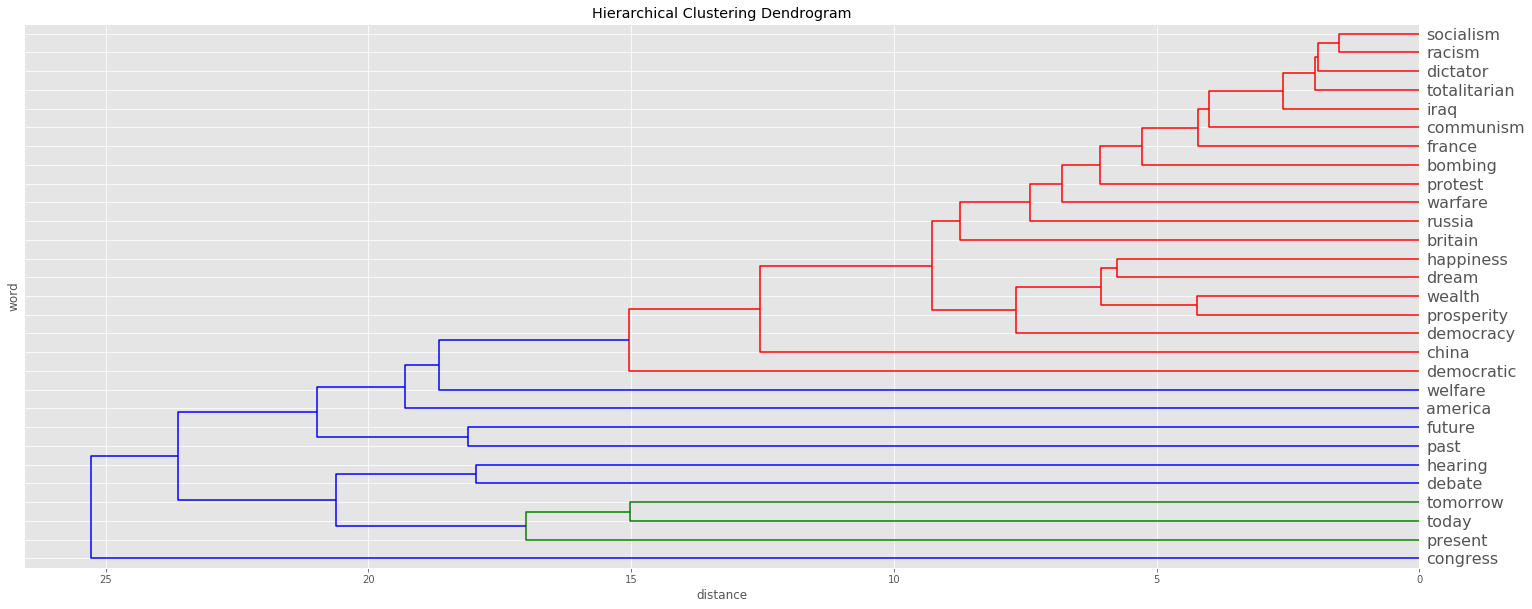

In [78]:
from matplotlib import pyplot as plt

l = links

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=16,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(keywords[v])
)
plt.show()


With a little tweaking, you can create a list of only those vectors for the words most of interest to you, using GENSIM to visualize their similarity to each other in the corpus.

You could even -- like Connell's blog entry indicates -- create a separate dendrogram for 1985 and another for 2005, to see how these terms have changed.

## Subtracting Vectors

You'll recall that we've used vector subtraction before.  Subtracting the context for "woman" from the context for "man" produces a vector of high scores for the words that only appear around "man" but not woman.

In [79]:
diff = congress_model.wv['man'] - congress_model.wv['woman']
congress_model.wv.similar_by_vector(diff)

[('man', 0.8865554332733154),
 ('person', 0.5839686989784241),
 ('anyone', 0.5157653093338013),
 ('everyone', 0.5006527900695801),
 ('courage', 0.500137984752655),
 ('sense', 0.4854341149330139),
 ('reputation', 0.4779624938964844),
 ('legacy', 0.4758404493331909),
 ('always', 0.47562742233276367),
 ('humor', 0.4749537706375122)]

In [80]:
diff = congress_model.wv['woman'] - congress_model.wv['man']
congress_model.wv.similar_by_vector(diff)

[('authorizes', 0.4562259912490845),
 ('including', 0.43004336953163147),
 ('936', 0.4296428859233856),
 ('areasto', 0.4267686903476715),
 ('totaling', 0.4266100227832794),
 ('repeals', 0.4210183024406433),
 ('covering', 0.4205123782157898),
 ('supplementary', 0.4169660806655884),
 ('extends', 0.4141148328781128),
 ('hudindependent', 0.4129101037979126)]

### Visualizing Abstract Relatedness

The four words making up the analogy can be understood as points in space where each word represents a single point. These points represent words' relationships with one-another.

Let's borrow more of Sinykin's code to visualize the results.

In [81]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [82]:
#%matplotlib inline

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

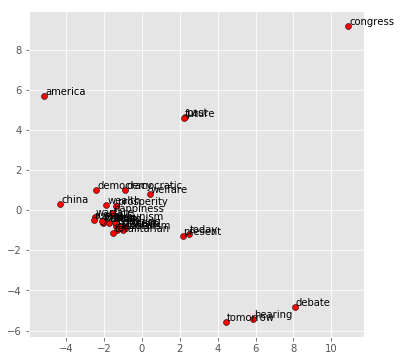

In [83]:
display_pca_scatterplot(congress_model.wv, keywords)

Truth be told, I don't love this visualization; it's visualizing abstract relationships that show the conceptual distance between different entities in the model. I present it to you as a cute toy, not as an approved visualization that i'd like to see in your work. 

Please use PCA analysis with care; it's almost impossible to get back to what it actually *means* -- at least without pairing it with other visualizations and measures.

## Studying Change Over Time with GENSIM

If we want to go further and use GENSIM as a tool for studying change over time, we'll want to organize the data by the features of the data that we care about.

In this case, we want to be able to investigate keywords, but also 5-year-periods.  We have a column called '5yrperiod,' and we want to make sure that this column is part of our dataset.


We'll want to organize the data by the features of the data that we care about -- the period.

Here are the names of the unique periods in this dataset:

In [13]:
periodnames = sample_m['5yrperiod'].unique().tolist()
periodnames

[1965.0, 1970.0, 1975.0, 1980.0]

Now that we have a list of periods, we can tell Gensim to make a 'model' for each period. And we can use these models to compare how the usage of each word changes over time.

***The following line of code might take a while, since we're creating 6 different gensim models. Fortunately, we're saving all of them, so if you want to go back and run this for a different word later, you can just load the old data rather than running the whole thing again.  If you want to rerun the code, follow the directions in the code below to hashtag out the gensim command and instead use the period_model = genseim-models-Word2Vec.load() command to load the old data -- it will be much less time consuming.***

In [19]:
dataname = 'sample-m'

In [65]:
cd '/scratch/group/history/hist_3368-jguldi/congress-embeddings'

/scratch/group/history/hist_3368-jguldi/congress-embeddings


In [81]:
for period1 in periodnames:
    print('working on ', period1)

    period_data = sample_m[sample_m['5yrperiod'] == period1] # select one period at a time
    print('mining ', period1)
    sentences = sentences_m # if you don't already have this, the code to make it is: make_sentences(sample_m['speech']).copy() # break data into sentences for that period only 
    ####### tweak here after the first run to use the old data without generating it again
    period_model = gensim.models.Word2Vec( # make a gensim model for that data
        sentences = sentences,
        min_count = 2, 
        size = 100)  
    period_model.save(dataname + '-model-' + str(period1)) # save the model with the name of the period
    #period_model = gensim.models.Word2Vec.load(dataname + '-model-' + str(period1)) # to load a saved model


mining  1970.0
mining  1975.0
mining  1980.0
mining  1965.0


As a result of this code, we have saved in the congress-embeddings folder a "period model" labeled with the name of your data and each period.  We can call up each period one at a time to get information about how any individual words were talked about.  

### Search the Period Models for a Keyword

The period models aren't very interesting in themselves, but they allow us to efficiently search for how the context of a keyword changes over time.

Let's search each 5-yr-period for a keyword and save the results as the variable *keyword_context*.

In [20]:
keyword1 = 'women'

In [66]:
dataname = 'sample-m'

In [67]:
cd '/scratch/group/history/hist_3368-jguldi/congress-embeddings'

/scratch/group/history/hist_3368-jguldi/congress-embeddings


In [68]:
#########  after the first run, use this line to call the old data without generating it again
keyword_context = []
dates_found = []

for p in range(len(periodnames)) :

    period1 = periodnames[p]
    print('working on ', period1)
    period_model = gensim.models.Word2Vec.load(dataname + '-model-' + str(period1)) # to load a saved model

    ## analysis
    if keyword1 in period_model.wv.vocab:
        print('found ', keyword1)
        
        keyword_vector = congress_model.wv[keyword1]
        keyword_context_period = period_model.wv.similar_by_vector(keyword_vector, topn = 5000) # extract the context of how women were talked about in that period

        keyword_context.append(keyword_context_period) # save the context of how women were talked about for later
        dates_found.append(period1)

working on  1965.0
found  women
working on  1970.0
found  women
working on  1975.0
found  women
working on  1980.0
found  women


The variable *keyword_context* is a list of vectors, each of which corresponds to a period.

   * keyword_context[0] is a vector of the words that most frequently occurred with keyword1 in 1965
   * keyword_context[1] is a vector of the words that most frequently occurred with keyword1 in 1970
   * keyword_context[2] is a vector of the words that most frequently occurred with keyword1 in 1975
   * ...and so on
   
We can use this list of vectors to study how the context of 'woman' was changing from period to period.

In [69]:
keyword_context[0][0:15]

[('gratitude', 0.3412187993526459),
 ('moments', 0.3360845148563385),
 ('staff', 0.3293425738811493),
 ('aroused', 0.3217255473136902),
 ('tending', 0.32093480229377747),
 ('privilege', 0.3143194317817688),
 ('couple', 0.3132251501083374),
 ('appreciation', 0.3118223547935486),
 ('ann', 0.3114094138145447),
 ('reaganomics', 0.3056735396385193),
 ('district', 0.30399295687675476),
 ('postcloture', 0.3003885746002197),
 ('hometown', 0.30025213956832886),
 ('honor', 0.2998431921005249),
 ('renovated', 0.2994152307510376)]

I can also grab just the names from the keyword vectors this way:

In [70]:
[item[0] for item in keyword_context[1]][:5]

['questionthat', 'esteemed', 'robbins', 'staff', 'volunteered']

I can grab just the numbers for any given year (in this case, the second period -- 1990 -- [1]) this way:

In [71]:
[item[1] for item in keyword_context[1]][:5]

[0.3689044117927551,
 0.3350377082824707,
 0.3323596715927124,
 0.33085188269615173,
 0.3293708860874176]

#### Visualize it

## Visualize it

In [72]:
# helper function to abstract only unique values while keeping the list in the same order -- the order of first appearance
def unique2(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

Make a flattened list of all the words.

In [73]:
all_words = []
for i in range(len(dates_found)):
    words = [item[0] for item in keyword_context[i]][:10]
    all_words.append(words)

all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

numwords = 10


Set up the colors.

In [74]:
from numpy import linspace
from matplotlib import cm
colors = [ cm.jet(x) for x in linspace(.5, 2, 50) ]

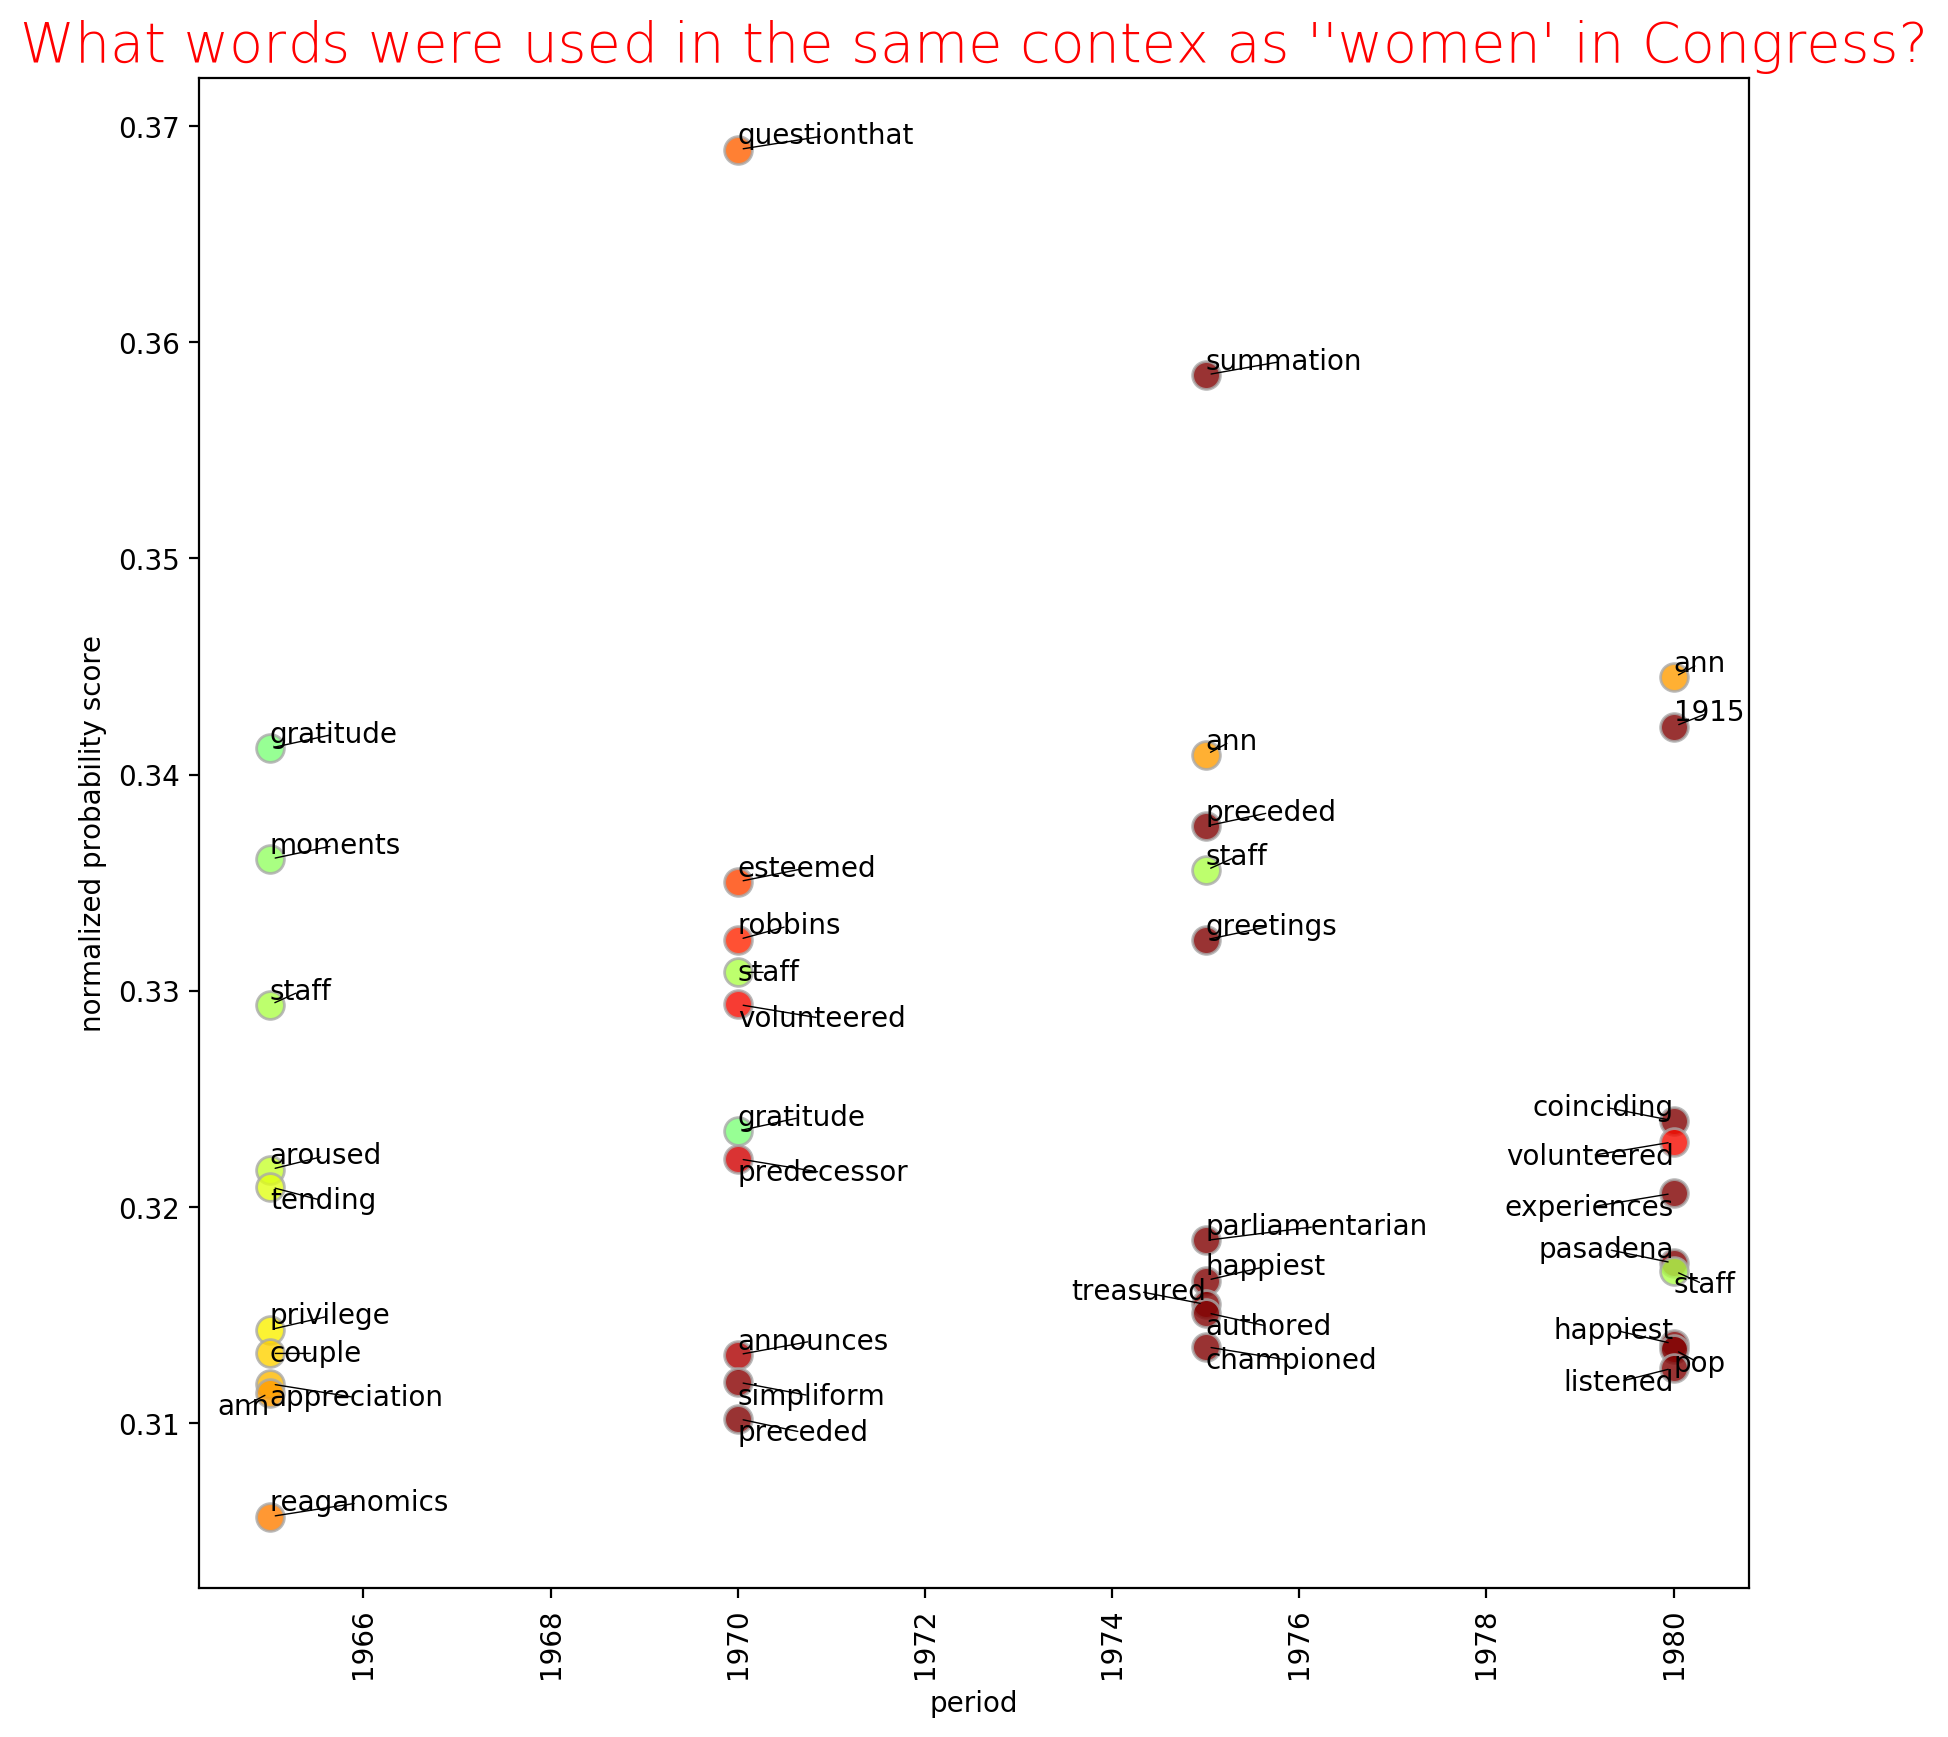

In [77]:
%matplotlib inline
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from adjustText import adjust_text

# change the figure's size here
plt.figure(figsize=(10,10), dpi = 200)

texts = []

# plt.annotate only plots one label per iteration, so we have to use a for loop 
for i in range(len(dates_found)):    # cycle through the period names
    
    #yyy = int(keyword_per_year[keyword_per_year['5yrperiod'] == int(xx)]['count'])   # how many times was the keyword used that year?
                     
    for j in range(10):     # cycle through the first ten words (you can change this variable)
        
        xx = dates_found[i]        # on the x axis, plot the period name
        yy = [item[1] for item in keyword_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
        txt = [item[0] for item in keyword_context[i]][j]        # grab the name of each collocated word
        colorindex = unique2(all_words2).index(txt)   # this command keeps all dots for the same word the same color
        
        plt.scatter(                                             # plot dots
            xx, #x axis
            yy, # y axis
            linewidth=1, 
            color = colors[colorindex],
            edgecolors = 'darkgray',
            s = 100, # dot size
            alpha=0.8)  # dot transparency

        # make a label for each word
        texts.append(plt.text(xx, yy, txt))

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=.7, 
                    expand_points=(1, 1), expand_text=(1, 1),
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xticks(rotation=90)

# Add titles
plt.title("What words were used in the same contex as ''" + keyword1 + "' in Congress?", fontsize=20, fontweight=0, color='Red')
plt.xlabel("period")
plt.ylabel("normalized probability score")


filename = 'words-used-in-context-of-' + keyword1 + '-' + dataname
plt.savefig(filename)

## Assignment

This week, you may choose a coding-intensive exercise OR an interpretive research question.

You do not have to do both.

#### Coding-intensive exercise
   * Create a list of keywords that you think would be particularly relevant for Congress during this time -- something that might demonstrate historical change in ideas.
        * Using the code above, create a GENSIM model for 1985, 1995, and 2005
        * Using the code above, create an array of vectors for your words for each time period
        * Using the code above, draw a dendrogram of keyword relatedness for the three time periods.
   * The code for the final visualization above shows the most common words used in the context of a keyword.  Tweak the code so that instead of showing *the keyword's context*, the visualization shows the *words that share the same context as the keyword in question.* This tweak should require about two lines of code.
     
        * Use the final visualization that you created above and its variation as the basis for an interpretive essay of one page.




#### Interpretive Research Question

In the code above, we learned how to streamline code to make it run over the complete data set.

Now that you can process *all* the data, you're ready for a more serious engagement with interpretation of historical questions, like:

* What are some of the ideas that changed in Congress over this time period? For instance, historians of this period frequently talk about the rise of a free-market ideology, a critique of the welfare state, arguments about the nature of democracy and America's role abroad. Can you support an argument about intellectual change on the basis of the changing context in which words were discussed?
* What groups of people were talked about in this period, and did the way they were spoken about change? Consider the role of women, minorities, the gay movement, and individuals who identify as religious in your answer.
* How did America's relationship with other nations change during this time period?  A historian might consider, for starters, the fall of the Berlin Wall in 1989 and the disintegration of the former USSR; the rise of terrorism, and the identification of Iraq, Iran, and Afghanistan as a frontier for US pacification; the border with Mexico and issues of immigration. Can you find systematic evidence of when and how one or more of these conversations changed in the data?

Choose one of the above questions. Iterate through a series of keyword queries and data results that would support a robust answer. Formulate an answer with at least one visualization and a page of writing, single-spaced, which analyze historical change in detail.

Turn in your work on Canvas. Do not turn in an ipynb. 